# Dogs vs Cats using CNN - Augmentations and Transfer Learning😺🐶

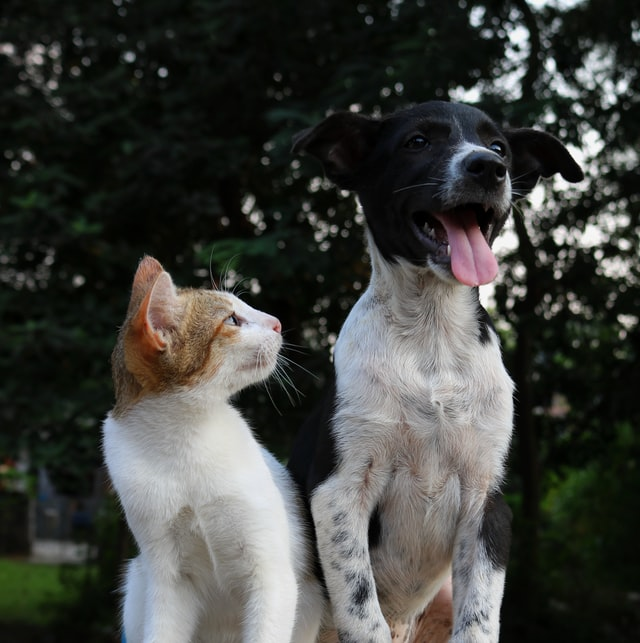

Here is a link to the first notebook, performing Basic CNN on Cats and Dogs - https://www.kaggle.com/ggsri123/dogsvscats

In this notebook, we will take a step further into exploring the ways by which we can achieve higher metric of accuracy.

Techniques used:
- Augmentations
- Transfer Learning

### Augmentation
Image augmentation is a technique of altering the existing data to create some more data for the model training process. In other words, it is the process of artificially expanding the available dataset for training a deep learning model.
Since all these images are generated from training data itself we don’t have to collect them manually. This increases the training sample without going out and collecting this data. Note that, the label for all the images will be the same and that is of the original image which is used to generate them.
In the real world, we might encounter various scenarios, such as the following:
- Images are rotated slightly
- Images are zoomed in/out (scaled)
- Some amount of noise is present in the image
- Images have low brightness
- Images have been flipped
- Images have been sheared (one side of the image is more twisted)



### Transfer learning
We use transfer learning when there is not enough data, or there is not enough time to train. But what are its benefits?

Better initial model: In other types of learning, you need to build a model without any knowledge. Transfer learning offers a better starting point and can perform tasks at some level without even training.
Higher learning rate: Transfer learning offers a higher learning rate during training since the problem has already been trained for a similar task.
Higher accuracy after training: With a better starting point and higher learning rate, transfer learning provides a machine learning model to converge at a higher performance level, enabling more accurate output.
Faster training: The learning can achieve the desired performance faster than traditional learning methods since it leverages a pre-trained model.
However, the performance of transfer learning might not be much higher than traditional learning models. The impact of transfer learning cannot be determined until the target model is developed.


In [ ]:
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tqdm
import shutil

## Using the pre-trained weights 
- wget the weights from the link, and add them to a file named /tmp/
- Later load it in a variable named local_weights_file

In [ ]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  

## Pre-trained Models

- The keras.application hosts a model called Inception-v3 developed by Google
- We use the pre-trained weights in .h5 file stored in the file /tmp
- We mention include_top = False, to notify the model that the end classification layer of the inception has to be removed. This is replaced with our custom Dense layers and classification layer, to be used for the classfication of Dogs-v-cats
- Lastly, the last layer is stored in a variable to be used in the functional API

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

### Functional API
- This is an alternative approach to sequential API
- Functional API brings in certain advantages like, transfer learning, multiple outputs, etc
- The last layer of inception is now conveniently mapped with the layers that we desire, i.e., flatten, custom Dense, Dropout and a classfication Dense layer

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


### File Extraction and storing to be accessed by ImageDataGenerator class

In [ ]:
#unpacking training and test
zip_ref = zipfile.ZipFile("../input/dogs-vs-cats/test1.zip", 'r')
zip_ref.extractall("../tmp/dogs-vs-cats")
zip_ref.close()

In [ ]:
zip_ref = zipfile.ZipFile("../input/dogs-vs-cats/train.zip", 'r')
zip_ref.extractall("../tmp/dogs-vs-cats")
zip_ref.close()

In [ ]:
!ls ../tmp/dogs-vs-cats/

In [ ]:
base_dir = '../tmp/dogs-vs-cats'
train_dir = os.path.join(base_dir, 'train')
testing_dir = os.path.join(base_dir, 'test1')

In [ ]:
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = train_dir + '/'
# plot first few images
for i in range(9):
	# define subplot
    pyplot.subplot(330 + 1 + i)
	# define filename
    filename = folder + 'cat.' + str(i) + '.jpg'
	# load image pixels
    image = imread(filename)
	# plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

In [ ]:
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = train_dir + '/'
# plot first few images
for i in range(9):
	# define subplot
    pyplot.subplot(330 + 1 + i)
	# define filename
    filename = folder + 'dog.' + str(i) + '.jpg'
    
	# load image pixels
    print(filename)
    
    image = imread(filename)
   
	# plot raw pixel data
    pyplot.imshow(image)
    # show the figure

pyplot.show()

In [ ]:
train_file_list = os.listdir('../tmp/dogs-vs-cats/train')
print('Num of images:', len(train_file_list))

dog_filenames = [fn for fn in train_file_list if fn.startswith('dog')]
cat_filenames = [fn for fn in train_file_list if fn.startswith('cat')]

dataset_filenames = train_test_split(
    dog_filenames, cat_filenames, test_size=0.1, shuffle=True, random_state=42
)


train_dog, valid_dog, train_cat, valid_cat  = [fns for fns in dataset_filenames]


train_dog_total, valid_dog_total, train_cat_total, valid_cat_total = [len(fns) for fns in dataset_filenames]
train_total = train_dog_total + train_cat_total
valid_total = valid_dog_total + valid_cat_total
print('Train: {}, test: {}'.format(train_total, valid_total))

In [ ]:
TRAIN_DIR_DOG = train_dir + '/dog'
TRAIN_DIR_CAT = train_dir + '/cat'

valid_dir = base_dir + '/valid'
VALID_DIR_DOG = valid_dir + '/dog'
VALID_DIR_CAT = valid_dir + '/cat'

In [ ]:
make_dirs = [TRAIN_DIR_DOG, VALID_DIR_DOG, TRAIN_DIR_CAT, VALID_DIR_CAT]
for dir, fns in zip(make_dirs, dataset_filenames):
    os.makedirs(dir, exist_ok=True)
    for fn in tqdm.tqdm(fns):
        shutil.move(os.path.join(train_dir, fn), dir)
    print('elements in {}: {}'.format(dir, len(os.listdir(dir))))

In [ ]:
!ls ../tmp/dogs-vs-cats/train

### Augmentations

- Augmentations is particularly done to enhance the number of images to help us get more training data in different shape, size, orientation, etc
- Here, rescaling is done (/255), rotated, width and height shifted, sheared, zoomed and horizontally flipped by a certain amount to create the necessary augmentation

In [ ]:
# All images will be rescaled by 1./255
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        valid_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

history = model.fit(
      train_generator,
      steps_per_epoch=50,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)



## A comparison 

- Dogs-vs-cats first code[1], using Basic CNN  vs this code which uses augmentations and transfer learning[2]
- The [1] basic CNN dogs-vs-cats classification started out with a validation accuracy of 0.5720, and ended with 0.8200 after 50 epochs
- The [2] transfer-learning augmented code started out with a validation accuracy of 0.9260 and ended up with 0.9650 after 15 epochs

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### What are the main benefits of Transfer Learning?

We use transfer learning when there is not enough data, or there is not enough time to train. But what are its benefits?

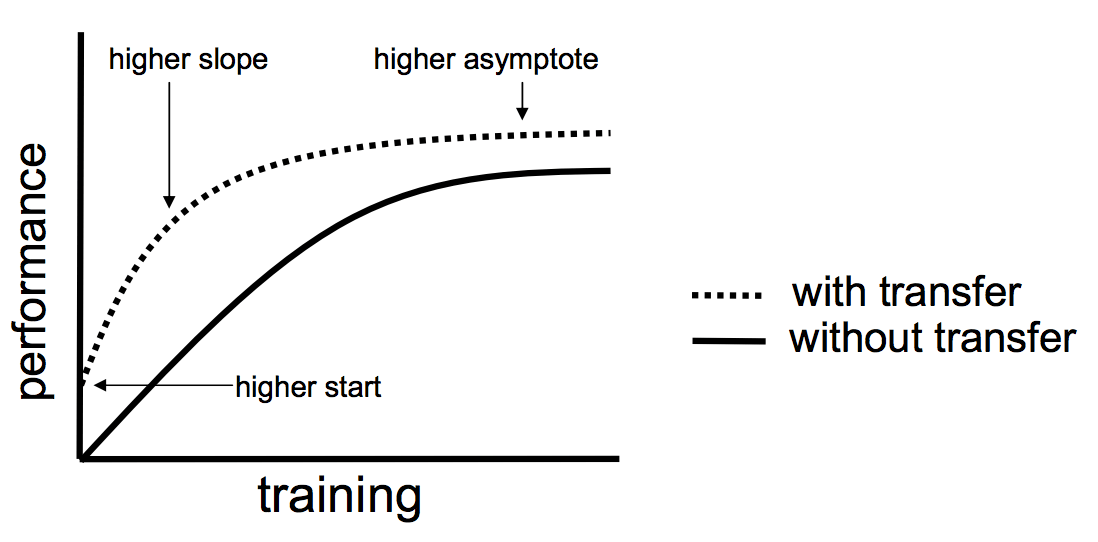


- Better initial model: In other types of learning, you need to build a model without any knowledge. Transfer learning offers a better starting point and can perform tasks at some level without even training.
- Higher learning rate: Transfer learning offers a higher learning rate during training since the problem has already trained for a similar task.
- Higher accuracy after training: With a better starting point and higher learning rate, transfer learning provides a machine learning model to converge at a higher performance level, enabling more accurate output.
- Faster training: The learning can achieve the desired performance faster than traditional learning methods since it leverages a pre-trained model.

However, the performance of transfer learning might not be much higher than traditional learning models. The impact of transfer learning cannot be determined until the target model is developed.

Source - [here](https://research.aimultiple.com/transfer-learning/)